In [1]:
import torch.nn as nn

# Model definition: SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Setting up VOC dataset structure...
Dataset setup complete.

ARCH: resnet18
Loading CropMix weights from disk...
  Training resnet18 [CropMix]...
    -> CropMix Done (268s). Final Loss: 0.2150 | Final Acc: 0.9258
Loading NoCropMix weights from disk...
  Training resnet18 [NoCropMix]...
    -> NoCropMix Done (219s). Final Loss: 0.2331 | Final Acc: 0.9241
Loading FineTuning weights from disk...
  Training resnet18 [FineTuning]...
    -> FineTuning Done (220s). Final Loss: 0.2151 | Final Acc: 0.9308
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s] 


  Training resnet18 [ImageNet]...
    -> ImageNet Done (217s). Final Loss: 0.1270 | Final Acc: 0.9544
  Training resnet18 [Random]...
    -> Random Done (214s). Final Loss: 0.2309 | Final Acc: 0.9234


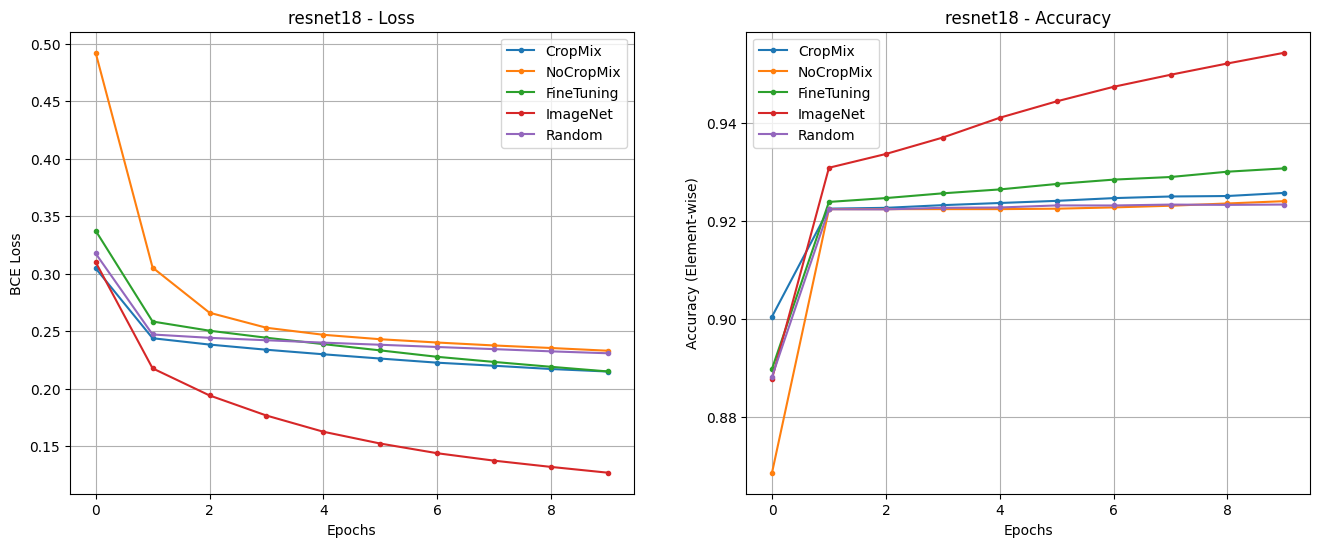


ARCH: resnet50
Loading CropMix weights from disk...
  Training resnet50 [CropMix]...
    -> CropMix Done (315s). Final Loss: 0.2094 | Final Acc: 0.9268
Loading NoCropMix weights from disk...
  Training resnet50 [NoCropMix]...
    -> NoCropMix Done (314s). Final Loss: 0.2306 | Final Acc: 0.9237
Loading FineTuning weights from disk...
  Training resnet50 [FineTuning]...
    -> FineTuning Done (314s). Final Loss: 0.2539 | Final Acc: 0.9226
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


  Training resnet50 [ImageNet]...
    -> ImageNet Done (314s). Final Loss: 0.1493 | Final Acc: 0.9460
  Training resnet50 [Random]...
    -> Random Done (314s). Final Loss: 0.2445 | Final Acc: 0.9222


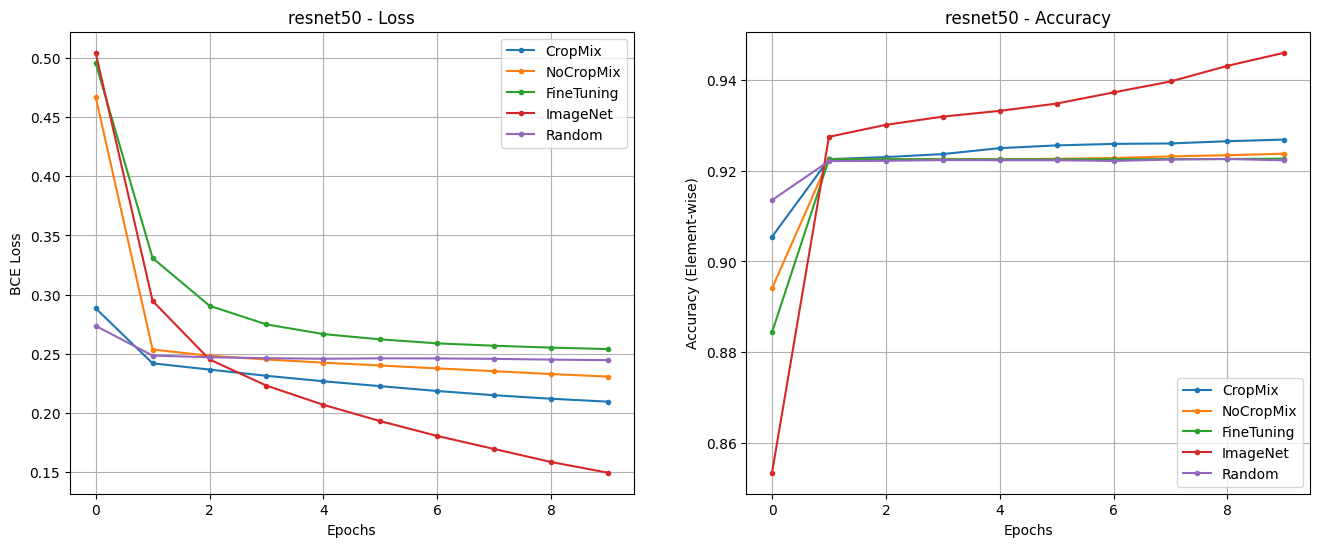


ARCH: efficientnet_b0
Loading CropMix weights from disk...
  Training efficientnet_b0 [CropMix]...
    -> CropMix Done (225s). Final Loss: 0.2400 | Final Acc: 0.9225
Loading NoCropMix weights from disk...
  Training efficientnet_b0 [NoCropMix]...
    -> NoCropMix Done (226s). Final Loss: 0.3097 | Final Acc: 0.9240
Loading FineTuning weights from disk...
  Training efficientnet_b0 [FineTuning]...
    -> FineTuning Done (223s). Final Loss: 0.2481 | Final Acc: 0.9234
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 153MB/s]

  Training efficientnet_b0 [ImageNet]...


    -> ImageNet Done (233s). Final Loss: 0.2148 | Final Acc: 0.9318
  Training efficientnet_b0 [Random]...
    -> Random Done (241s). Final Loss: 0.2413 | Final Acc: 0.9225


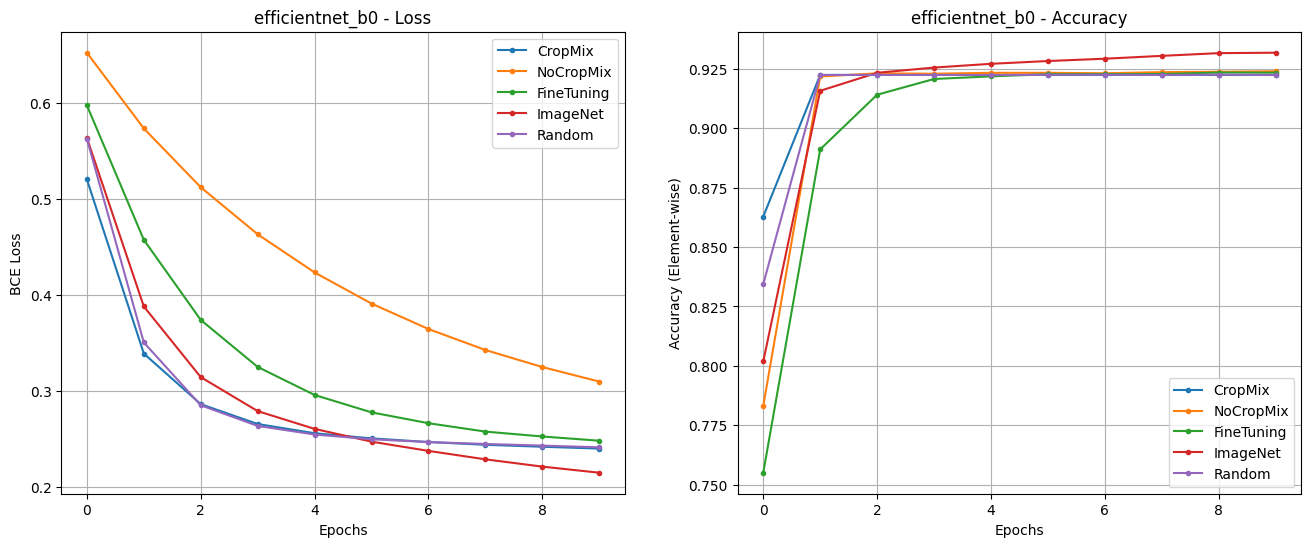


ARCH: efficientnet_b3
>> Switching to 300x300 for efficientnet_b3
Loading CropMix weights from disk...
  Training efficientnet_b3 [CropMix]...
    -> CropMix Done (703s). Final Loss: 0.3410 | Final Acc: 0.9225
Loading NoCropMix weights from disk...
  Training efficientnet_b3 [NoCropMix]...
    -> NoCropMix Done (702s). Final Loss: 0.2998 | Final Acc: 0.9256
Loading FineTuning weights from disk...
  Training efficientnet_b3 [FineTuning]...
    -> FineTuning Done (702s). Final Loss: 0.2542 | Final Acc: 0.9229
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 194MB/s]


  Training efficientnet_b3 [ImageNet]...
    -> ImageNet Done (703s). Final Loss: 0.2269 | Final Acc: 0.9300
  Training efficientnet_b3 [Random]...
    -> Random Done (703s). Final Loss: 0.2483 | Final Acc: 0.9225


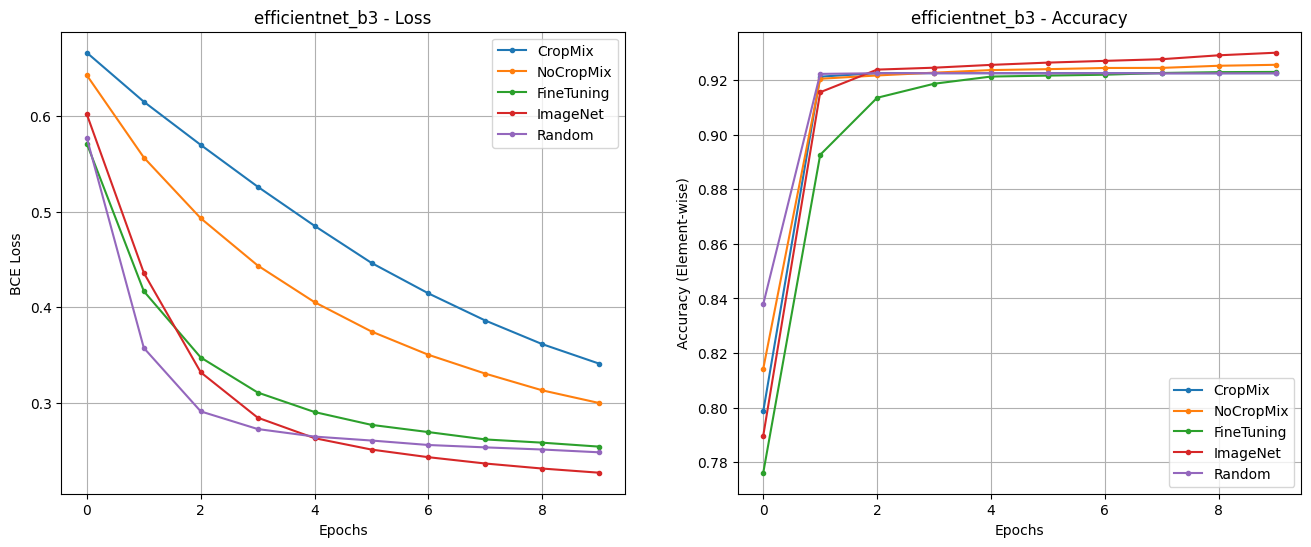


ARCH: inception_v3
>> Switching to 299x299 for inception_v3


/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Loading CropMix weights from disk...
  Training inception_v3 [CropMix]...
    -> CropMix Done (516s). Final Loss: 0.2397 | Final Acc: 0.9226
Loading NoCropMix weights from disk...
  Training inception_v3 [NoCropMix]...
    -> NoCropMix Done (523s). Final Loss: 0.3406 | Final Acc: 0.9225
Loading FineTuning weights from disk...
  Training inception_v3 [FineTuning]...
    -> FineTuning Done (517s). Final Loss: 0.2026 | Final Acc: 0.9337
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 219MB/s] 


  Training inception_v3 [ImageNet]...
    -> ImageNet Done (524s). Final Loss: 0.2024 | Final Acc: 0.9485
  Training inception_v3 [Random]...
    -> Random Done (516s). Final Loss: 0.2433 | Final Acc: 0.9225


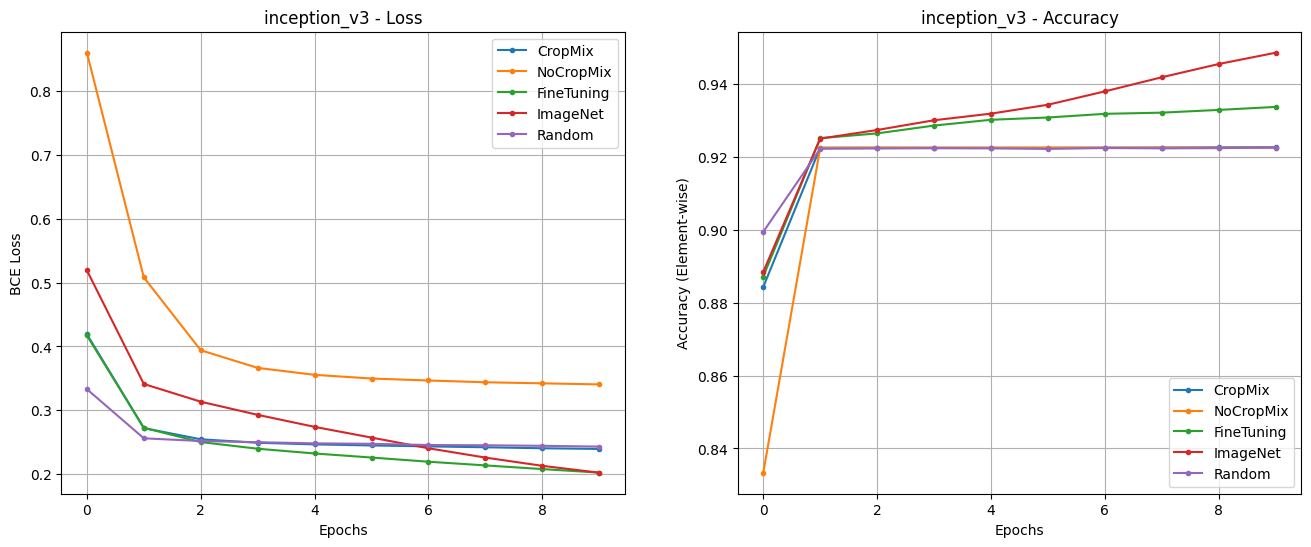


ARCH: simple_CNN
Loading CropMix weights from disk...
  Training simple_CNN [CropMix]...
    -> CropMix Done (209s). Final Loss: 0.2580 | Final Acc: 0.9221
Loading NoCropMix weights from disk...
  Training simple_CNN [NoCropMix]...
    -> NoCropMix Done (211s). Final Loss: 0.2568 | Final Acc: 0.9214
  Training simple_CNN [Random]...
    -> Random Done (212s). Final Loss: 0.2462 | Final Acc: 0.9231


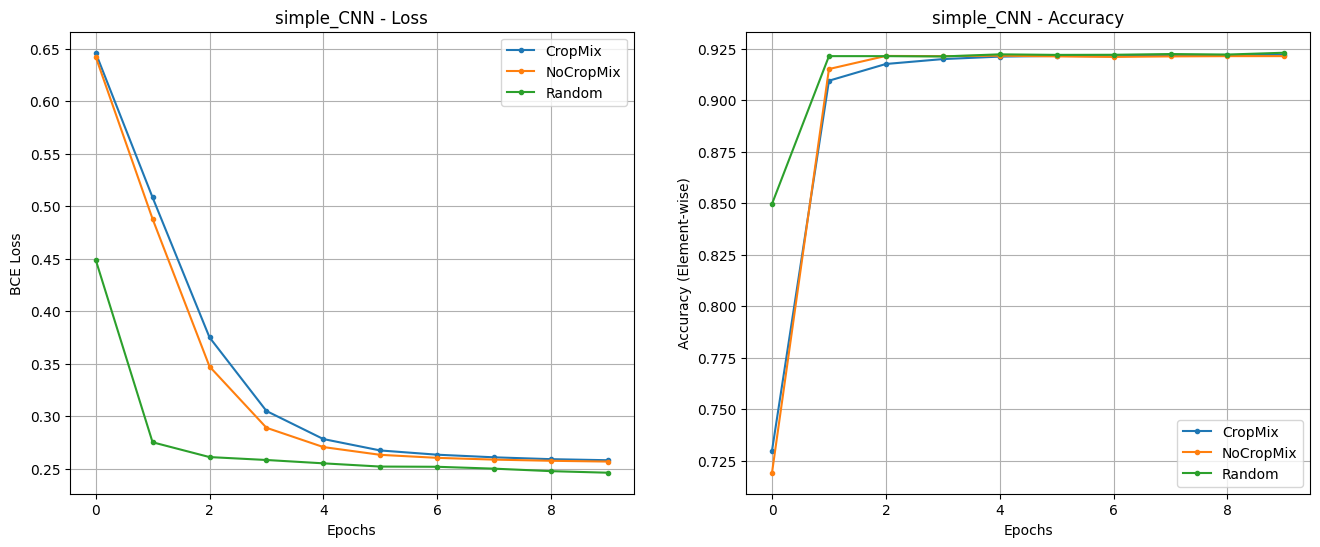


All comparisons complete.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import shutil

# --- 1. CONFIGURATION ---
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 10 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path Setup
PATH_TASK = '/kaggle/input/image-orientation-pretext-task-models/pytorch/default/1'

model_configs = {
    'resnet18': {
        'CropMix':    f'{PATH_TASK}/fullTraining_ResNet18.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_ResNet18_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_ResNet18.pth',
    },
    'resnet50': {
        'CropMix':    f'{PATH_TASK}/fullTraining_ResNet50.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_ResNet50_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_ResNet50.pth',
    },
    'efficientnet_b0': {
        'CropMix':    f'{PATH_TASK}/fullTraining_EfficientNetB0.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_EfficientNetB0_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_EfficientNetB0.pth',
    },
    'efficientnet_b3': {
        'CropMix':    f'{PATH_TASK}/fullTraining_EfficientNetB3.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_EfficientNetB3_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_EfficientNetB3.pth',
    },
    'inception_v3': {
        'CropMix':    f'{PATH_TASK}/fullTraining_InceptionV3.pth',
        'NoCropMix':  f'{PATH_TASK}/fullTraining_InceptionV3_nocropmix.pth',
        'FineTuning': f'{PATH_TASK}/fineTuning_InceptionV3.pth',
    },
    'simple_CNN':{
        'CropMix':    f'{PATH_TASK}/SimpleRotationCNN.pth',
        'NoCropMix':  f'{PATH_TASK}/SimpleRotationCNN224_nocropmix.pth',
    }
}

VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# --- 2. AUTOMATIC DATASET SETUP ---
def setup_voc_structure():
    input_root = '/kaggle/input/pascal-voc-2012-dataset'
    working_voc_dir = '/kaggle/working/VOCdevkit/VOC2012'
    
    if os.path.exists(working_voc_dir) and os.path.exists(os.path.join(working_voc_dir, 'JPEGImages')):
        print("Dataset structure already exists.")
        return

    print("Setting up VOC dataset structure...")
    source_voc_dir = None
    for root, dirs, files in os.walk(input_root):
        if 'JPEGImages' in dirs:
            source_voc_dir = root
            break
            
    if not source_voc_dir:
        raise FileNotFoundError("Could not find VOC data in input!")

    os.makedirs(working_voc_dir, exist_ok=True)
    
    folders = ['Annotations', 'ImageSets', 'JPEGImages', 'SegmentationClass', 'SegmentationObject']
    for folder in folders:
        src = os.path.join(source_voc_dir, folder)
        dst = os.path.join(working_voc_dir, folder)
        if os.path.exists(src) and not os.path.exists(dst):
            os.symlink(src, dst)
            
    print("Dataset setup complete.")

setup_voc_structure()

# --- 3. DATASET HANDLING & TRANSFORMS ---
class PascalVOC_Classification(datasets.VOCDetection):
    def __init__(self, root, year, image_set, download=False, transform=None):
        super().__init__(root, year, image_set, download=download, transform=transform)
        self.class_to_idx = {name: i for i, name in enumerate(VOC_CLASSES)}

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        label_vector = torch.zeros(20, dtype=torch.float32)
        objects = target['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]
        for obj in objects:
            class_name = obj['name']
            if class_name in self.class_to_idx:
                idx = self.class_to_idx[class_name]
                label_vector[idx] = 1.0
        return img, label_vector

# Define transforms
transform_standard = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_efficientNetB3 = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize Dataset
train_dataset = PascalVOC_Classification( root='/kaggle/working', year='2012', image_set='train', download=False, transform=transform_standard)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


# --- 4. MODEL BUILDER (FIXED FOR INCEPTION) ---
def build_model(architecture, variant, custom_path=None):
    # 1. Determine if we need AuxLogits (Only for Inception)
    use_aux = False
    if architecture == 'inception_v3':
        if variant == 'NoCropMix' or variant == 'ImageNet':
            use_aux = True
    
    # 2. Initialize Base Model
    if architecture == 'simple_CNN':
        model = SimpleCNN(num_classes=20)
    else:
        if variant == 'ImageNet':
            model = getattr(models, architecture)(weights='DEFAULT')
        else:
            if architecture == 'inception_v3':
                model = getattr(models, architecture)(weights=None, aux_logits=use_aux)
            else:
                model = getattr(models, architecture)(weights=None)
    
    # 3. Load Custom Weights
    if variant in ['CropMix', 'NoCropMix', 'FineTuning'] and custom_path:
        if not os.path.exists(custom_path):
            print(f"!! ERROR: File not found {custom_path}. Using Random weights !!")
        else:
            print(f"Loading {variant} weights from disk...")
            checkpoint = torch.load(custom_path, map_location='cpu')
            state_dict = checkpoint.state_dict() if isinstance(checkpoint, nn.Module) else \
                         checkpoint.get('state_dict', checkpoint)
            
            if list(state_dict.keys())[0].startswith('module.'):
                state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
            
            filtered_dict = {k: v for k, v in state_dict.items() 
                             if not ('fc' in k or 'classifier' in k or 'AuxLogits' in k)}
            try:
                model.load_state_dict(filtered_dict, strict=False)
            except Exception as e:
                print(f"Error loading {variant}: {e}")

    # 4. Replace Head(s) for VOC (20 Classes)
    if 'resnet' in architecture:
        model.fc = nn.Linear(model.fc.in_features, 20)
    elif 'efficientnet' in architecture:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 20)
    elif 'inception' in architecture:
        model.fc = nn.Linear(model.fc.in_features, 20)
        # CRITICAL FIX: Resize Aux head if it exists
        if hasattr(model, 'AuxLogits') and model.AuxLogits is not None:
            model.AuxLogits.fc = nn.Linear(768, 20) 

    return model.to(DEVICE)


# --- 5. TRAINING FUNCTION (UPDATED FOR ACCURACY) ---
def train_model(model, arch_name, variant_name):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    
    loss_history = []
    acc_history = []  # Store accuracy per epoch
    
    model.train()
    print(f"  Training {arch_name} [{variant_name}]...")
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        running_corrects = 0
        total_elements = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            
            # --- Dynamic Forward Pass ---
            outputs = model(inputs)
            
            # Handle Inception Tuple (AuxLogits)
            if isinstance(outputs, tuple):
                main_out, aux_out = outputs
                loss1 = criterion(main_out, labels)
                loss2 = criterion(aux_out, labels)
                loss = loss1 + 0.4 * loss2
                logits_for_acc = main_out # Calculate accuracy on Main head only
            else:
                loss = criterion(outputs, labels)
                logits_for_acc = outputs
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # --- Calculate Accuracy (Element-wise) ---
            # Sigmoid > 0.5 is the standard threshold for Multi-label
            preds = (torch.sigmoid(logits_for_acc) > 0.5).float()
            
            # Count correct elements (Hamming Score numerator)
            # We compare the entire 20-length vector element by element
            running_corrects += (preds == labels).sum().item()
            total_elements += labels.numel() # Batch_Size * 20
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / total_elements
        
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

    return loss_history, acc_history


# --- 6. EXECUTION LOOP (UPDATED FOR SUBPLOTS) ---
for arch, paths in model_configs.items():
    print(f"\n{'='*60}")
    print(f"ARCH: {arch}")
    print(f"{'='*60}")

    if arch == 'simple_CNN':
        VARIANTS_TO_TEST = ['CropMix', 'NoCropMix', 'Random']
    else:
        VARIANTS_TO_TEST = ['CropMix', 'NoCropMix', 'FineTuning', 'ImageNet', 'Random']

    transform = transform_standard
    # 1. Handle Inception/EfficientNet Resize Logic
    if arch == 'inception_v3':
        print(f">> Switching to 299x299 for {arch}")
        transform = transform_inception
    elif arch == 'efficientnet_b3':
        print(f">> Switching to 300x300 for {arch}")
        transform = transform_efficientNetB3
    elif transform != transform_standard:
        print(f">> Switching to 224x224 for {arch}")
        transform = transform_standard

    train_dataset = PascalVOC_Classification( root='/kaggle/working', year='2012', image_set='train', download=False, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


    # 2. Prepare Plot (1 Row, 2 Columns: Loss | Accuracy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    
    for variant in VARIANTS_TO_TEST:
        custom_path = paths.get(variant, None)

        # Build
        model = build_model(arch, variant, custom_path)
        
        # Train & Record
        start_t = time.time()
        loss_hist, acc_hist = train_model(model, arch, variant)
        duration = time.time() - start_t
        
        # Plot Loss on Left (ax1)
        ax1.plot(loss_hist, label=f"{variant}", marker='.')
        
        # Plot Accuracy on Right (ax2)
        ax2.plot(acc_hist, label=f"{variant}", marker='.')
        
        print(f"    -> {variant} Done ({duration:.0f}s). Final Loss: {loss_hist[-1]:.4f} | Final Acc: {acc_hist[-1]:.4f}")

    # 3. Finalize Plots
    # Loss Plot details
    ax1.set_title(f'{arch} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('BCE Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy Plot details
    ax2.set_title(f'{arch} - Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (Element-wise)')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

print("\nAll comparisons complete.")